# 2. Time Series Clustering
    
# Imports

In [1]:
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from tslearn.clustering import TimeSeriesKMeans
from yellowbrick.cluster import KElbowVisualizer

# pd display options

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

#  Loading the data

In [3]:
df_energy = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl")

In [4]:
df_energy

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.030,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.101,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.201,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.833,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.440,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,...,9.390,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,...,4.141,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,...,6.767,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148
3246,0x47218b46abb2fcaade487a211911406dc6e13730,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,...,20.747,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201


# Looking at how many missing values we have

In [5]:
# how many nans do we have
nan_count = df_energy.drop("meter_id", axis=1).isnull().sum(axis = 0)
nan_count

2017-01-01    2983
2017-01-02    2980
2017-01-03    2980
2017-01-04    2980
2017-01-05    2980
              ... 
2017-12-27      10
2017-12-28      10
2017-12-29      10
2017-12-30      10
2017-12-31      10
Length: 365, dtype: int64

<AxesSubplot:title={'center':'Missing values per day'}, xlabel='date', ylabel='number of missing values'>

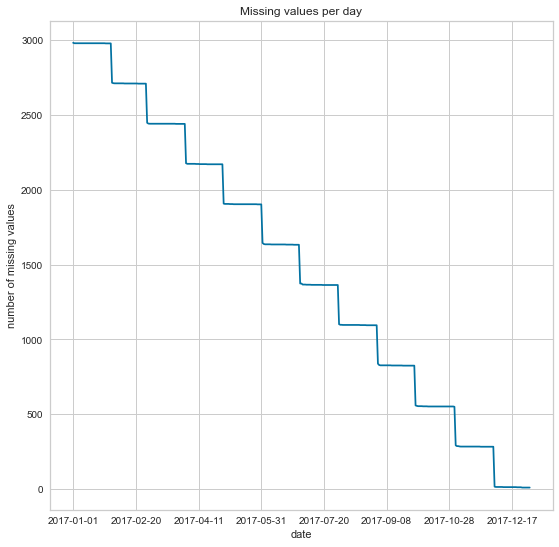

In [6]:
# plotting number of missing values
nan_count.plot(figsize=(9,9), title="Missing values per day", xlabel="date", ylabel="number of missing values")

#### Conclusions:
* We now know that the exists no single day where all meters have a reading
* The best we can get is a minimum of 11 missing values per day for the last 6 days of the year
    * This is likely as the battery in the meter has died.
* For the last 28 days we only have 21 different meters we are missing values for
* Before that it goes up exponentially making it impractical to use any more days than the last 28
    
* Plan is to:
    1. Create new dataframe of just the last 28 days
    2. Fill the missing values for the 15 that contain missing to 0
    3. Cluster the dataframe
    
* Questions is:
    * 1. just because they have similar patterns in december, are they likely to have similar patterns year round?
        * eg is this enough data to make a real conclusion on
            * Can determine this by making its use optional in hyper-parameter optimisation
        
        
        
* Also an interesting note is that, despite being billed as real data, it seems likely it has been tampered with due to the stepwise nature of missing values (looking like a staircase); possibly they manually set missing values from the real values?
        
# 1. Creating new dataframe of just the last 29 days 

## Checking how many missing values in last 29 days

In [7]:
# last 29 days have most reasonable amount of missing values
df_energy_last_29 = pd.concat([pd.DataFrame(df_energy["meter_id"]),df_energy.iloc[:,-29:]], axis=1)
df_energy_last_29

,meter_id,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,3.517,2.93300,3.08500,3.237,4.4710,3.7410,5.48250,7.224,4.951,...,4.030,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,18.057,18.34500,17.41900,16.493,17.2510,23.4690,24.09950,24.730,24.597,...,13.101,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,16.324,8.21138,9.81869,11.426,6.3985,20.0265,16.22475,12.423,18.379,...,10.201,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,14.012,23.07300,20.08750,17.102,14.1100,23.3150,21.49350,19.672,21.023,...,14.833,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,30.378,27.22400,29.92500,32.626,30.5070,35.3880,41.99750,48.607,54.760,...,39.440,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,10.054,10.32100,9.88000,9.439,9.6750,9.9760,10.30550,10.635,10.650,...,9.390,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,3.170,9.96700,7.92450,5.882,3.5980,5.8620,6.81600,7.770,5.091,...,4.141,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.727,6.03800,5.80150,5.565,5.7350,7.2410,6.46800,5.695,8.143,...,6.767,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148
3246,0x47218b46abb2fcaade487a211911406dc6e13730,25.614,29.31700,29.15450,28.992,23.8700,28.7260,29.28500,29.844,31.899,...,20.747,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201


In [8]:
# checking the number of missing values
df_energy_last_29.isnull().sum(axis = 0)

meter_id       0
2017-12-03    16
2017-12-04    14
2017-12-05    14
2017-12-06    14
              ..
2017-12-27    10
2017-12-28    10
2017-12-29    10
2017-12-30    10
2017-12-31    10
Length: 30, dtype: int64

In [9]:
df_energy_last_29

,meter_id,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,3.517,2.93300,3.08500,3.237,4.4710,3.7410,5.48250,7.224,4.951,...,4.030,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,18.057,18.34500,17.41900,16.493,17.2510,23.4690,24.09950,24.730,24.597,...,13.101,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,16.324,8.21138,9.81869,11.426,6.3985,20.0265,16.22475,12.423,18.379,...,10.201,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,14.012,23.07300,20.08750,17.102,14.1100,23.3150,21.49350,19.672,21.023,...,14.833,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,30.378,27.22400,29.92500,32.626,30.5070,35.3880,41.99750,48.607,54.760,...,39.440,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,10.054,10.32100,9.88000,9.439,9.6750,9.9760,10.30550,10.635,10.650,...,9.390,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,3.170,9.96700,7.92450,5.882,3.5980,5.8620,6.81600,7.770,5.091,...,4.141,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.727,6.03800,5.80150,5.565,5.7350,7.2410,6.46800,5.695,8.143,...,6.767,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148
3246,0x47218b46abb2fcaade487a211911406dc6e13730,25.614,29.31700,29.15450,28.992,23.8700,28.7260,29.28500,29.844,31.899,...,20.747,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201


In [10]:
df_energy_last_29[df_energy_last_29.isna().any(axis=1)]

,meter_id,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
10,0xb1bd18b68569dd962497a9802036e536c10cc6a4,NaN,4.744,3.8265,4.962,6.0765,4.2280,5.577500,7.689500,5.938000,...,13.90050,6.153000,2.919000,9.866000,6.487000,6.749000,4.124000,7.625000,5.371000,6.257000
76,0x77eec2c72ea2ebf10ca81254a3b7e85c6972ae68,NaN,4.066,4.2085,4.351,4.6540,4.1986,4.260633,4.322667,4.394333,...,4.02125,3.995962,3.923231,3.850500,3.767560,4.319530,4.871500,4.552690,4.233881,3.915071
236,0xe25a932a636d23f93439f1785706e2447f51e6b3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,55.49700,53.418000,55.875500,58.333000,73.960000,84.113000,94.266000,90.346500,86.427000,65.071000
257,0x81fa8eddb2b09393d3719984ca5520cb50f45efd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,0x2ce3d582a1316db5bcfe405cbd6070268944778e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.753000,9.367000,8.490000,7.613000,8.079000,8.545000,9.714000
452,0x795fa14a925f90f11752454da39988048db6e042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
515,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963,0x11f730d29bba6ceccf25bebb76ba0e36486bb069,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.084500,1.261500,...,0.88535,0.875300,0.865250,0.855201,0.845151,0.835101,0.825051,0.825051,0.825051,0.825051
1091,0xe41c230484378b2312fbf1fc99d289e0b51a3c52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## forward & backward filling to give a reasonable imputation to the missing values

In [11]:
#forward filling the missing values in the dataframe
meter_id = df_energy["meter_id"]
df_energy_no_meter_id  = df_energy.drop("meter_id", axis=1)
display(df_energy_no_meter_id)

#forward filling the missing values
df_energy_fill =df_energy_no_meter_id.bfill(axis="columns")
df_energy_fill = df_energy_fill.ffill(axis="columns")


# last 29 days have most reasonable amount of missing values
df_energy_last_29_fill = pd.concat([pd.DataFrame(meter_id),df_energy_fill.iloc[:,-29:]], axis=1)
display(df_energy_last_29_fill)

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.030,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.101,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.201,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.833,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.440,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,2.3040,...,9.390,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480
3244,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,10.3010,...,4.141,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401
3245,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,6.8355,...,6.767,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148
3246,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,24.6880,...,20.747,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201


,meter_id,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,3.517,2.93300,3.08500,3.237,4.4710,3.7410,5.48250,7.224,4.951,...,4.030,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,18.057,18.34500,17.41900,16.493,17.2510,23.4690,24.09950,24.730,24.597,...,13.101,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,16.324,8.21138,9.81869,11.426,6.3985,20.0265,16.22475,12.423,18.379,...,10.201,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,14.012,23.07300,20.08750,17.102,14.1100,23.3150,21.49350,19.672,21.023,...,14.833,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,30.378,27.22400,29.92500,32.626,30.5070,35.3880,41.99750,48.607,54.760,...,39.440,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,10.054,10.32100,9.88000,9.439,9.6750,9.9760,10.30550,10.635,10.650,...,9.390,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,3.170,9.96700,7.92450,5.882,3.5980,5.8620,6.81600,7.770,5.091,...,4.141,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.727,6.03800,5.80150,5.565,5.7350,7.2410,6.46800,5.695,8.143,...,6.767,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148
3246,0x47218b46abb2fcaade487a211911406dc6e13730,25.614,29.31700,29.15450,28.992,23.8700,28.7260,29.28500,29.844,31.899,...,20.747,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201


In [12]:
# checking the number of missing values
df_energy_last_29_fill.isnull().sum(axis = 0)

meter_id       0
2017-12-03    10
2017-12-04    10
2017-12-05    10
2017-12-06    10
              ..
2017-12-27    10
2017-12-28    10
2017-12-29    10
2017-12-30    10
2017-12-31    10
Length: 30, dtype: int64

In [13]:
df_energy_last_29_fill[df_energy_last_29.isna().any(axis=1)]

,meter_id,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
10,0xb1bd18b68569dd962497a9802036e536c10cc6a4,4.7440,4.7440,3.8265,4.9620,6.0765,4.2280,5.577500,7.689500,5.938000,...,13.90050,6.153000,2.919000,9.866000,6.487000,6.749000,4.124000,7.625000,5.371000,6.257000
76,0x77eec2c72ea2ebf10ca81254a3b7e85c6972ae68,4.0660,4.0660,4.2085,4.3510,4.6540,4.1986,4.260633,4.322667,4.394333,...,4.02125,3.995962,3.923231,3.850500,3.767560,4.319530,4.871500,4.552690,4.233881,3.915071
236,0xe25a932a636d23f93439f1785706e2447f51e6b3,71.6310,71.6310,71.6310,71.6310,71.6310,71.6310,71.631000,71.631000,71.631000,...,55.49700,53.418000,55.875500,58.333000,73.960000,84.113000,94.266000,90.346500,86.427000,65.071000
257,0x81fa8eddb2b09393d3719984ca5520cb50f45efd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291,0x2ce3d582a1316db5bcfe405cbd6070268944778e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,9.7530,9.7530,9.7530,9.7530,9.7530,9.7530,9.753000,9.753000,9.753000,...,9.75300,9.753000,9.753000,9.753000,9.367000,8.490000,7.613000,8.079000,8.545000,9.714000
452,0x795fa14a925f90f11752454da39988048db6e042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
515,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
963,0x11f730d29bba6ceccf25bebb76ba0e36486bb069,1.0845,1.0845,1.0845,1.0845,1.0845,1.0845,1.084500,1.084500,1.261500,...,0.88535,0.875300,0.865250,0.855201,0.845151,0.835101,0.825051,0.825051,0.825051,0.825051
1091,0xe41c230484378b2312fbf1fc99d289e0b51a3c52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#10 of the rows have NaN the entire year round so just use the mean of each day
for column in df_energy_last_29_fill.columns:
    if column == "meter_id":
        continue
    df_energy_last_29_fill[column].fillna((df_energy_last_29_fill[column].mean()), inplace=True)
df_energy_last_29_fill[df_energy_last_29.isna().any(axis=1)]

,meter_id,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,...,2017-12-22,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31
10,0xb1bd18b68569dd962497a9802036e536c10cc6a4,4.744000,4.744000,3.826500,4.962000,6.076500,4.228000,5.577500,7.689500,5.938000,...,13.900500,6.153000,2.919000,9.866000,6.487000,6.749000,4.124000,7.625000,5.371000,6.257000
76,0x77eec2c72ea2ebf10ca81254a3b7e85c6972ae68,4.066000,4.066000,4.208500,4.351000,4.654000,4.198600,4.260633,4.322667,4.394333,...,4.021250,3.995962,3.923231,3.850500,3.767560,4.319530,4.871500,4.552690,4.233881,3.915071
236,0xe25a932a636d23f93439f1785706e2447f51e6b3,71.631000,71.631000,71.631000,71.631000,71.631000,71.631000,71.631000,71.631000,71.631000,...,55.497000,53.418000,55.875500,58.333000,73.960000,84.113000,94.266000,90.346500,86.427000,65.071000
257,0x81fa8eddb2b09393d3719984ca5520cb50f45efd,12.299755,11.458734,11.261847,11.061499,10.982229,12.152306,13.120239,14.079027,13.217639,...,11.188745,11.644609,11.801521,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
291,0x2ce3d582a1316db5bcfe405cbd6070268944778e,12.299755,11.458734,11.261847,11.061499,10.982229,12.152306,13.120239,14.079027,13.217639,...,11.188745,11.644609,11.801521,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
377,0x306e6baa9367d3c43fa6ecc2d0054b207d6ef471,9.753000,9.753000,9.753000,9.753000,9.753000,9.753000,9.753000,9.753000,9.753000,...,9.753000,9.753000,9.753000,9.753000,9.367000,8.490000,7.613000,8.079000,8.545000,9.714000
452,0x795fa14a925f90f11752454da39988048db6e042,12.299755,11.458734,11.261847,11.061499,10.982229,12.152306,13.120239,14.079027,13.217639,...,11.188745,11.644609,11.801521,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
515,0x423fa805ddb0cba9bdb4460f9a78540287eefd0e,12.299755,11.458734,11.261847,11.061499,10.982229,12.152306,13.120239,14.079027,13.217639,...,11.188745,11.644609,11.801521,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495
963,0x11f730d29bba6ceccf25bebb76ba0e36486bb069,1.084500,1.084500,1.084500,1.084500,1.084500,1.084500,1.084500,1.084500,1.261500,...,0.885350,0.875300,0.865250,0.855201,0.845151,0.835101,0.825051,0.825051,0.825051,0.825051
1091,0xe41c230484378b2312fbf1fc99d289e0b51a3c52,12.299755,11.458734,11.261847,11.061499,10.982229,12.152306,13.120239,14.079027,13.217639,...,11.188745,11.644609,11.801521,11.942665,11.552484,12.231637,12.903379,12.511848,12.101536,11.881495


In [15]:
df_energy_last_29 = df_energy_last_29_fill

# 2. Clustering the dataframe
## Getting optimal euclidean K value via elbow

* Euclidean distance : not particularly adapted for time series

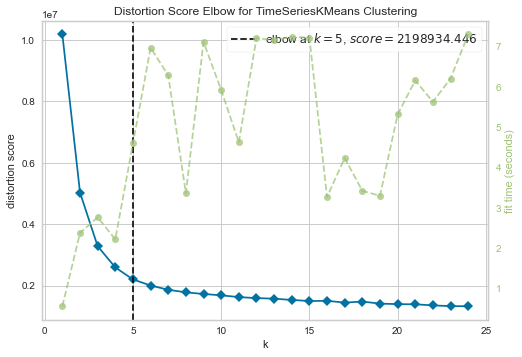

<AxesSubplot:title={'center':'Distortion Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
# elbow method for getting best value for k
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
if not os.path.exists(f"../EDA/plots/consumption/clustering/euclidean/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/euclidean/")


clusterer = TimeSeriesKMeans()
visualizer = KElbowVisualizer(clusterer, k=(1,25))

visualizer.fit(df_energy_last_29.drop("meter_id", axis=1))
# plt.title("TimeSeries kMeans Elbow")
plt.savefig("../EDA/plots/consumption/Clustering/euclidean/_elbow.png")
visualizer.show()

In [17]:
# k value (how many clusters)
k = 5

## Clustering via euclidean kmeans

In [18]:
#fitting the euclidean kmeans
clusterer = TimeSeriesKMeans(n_clusters=k)
clusterer.fit(df_energy_last_29.drop("meter_id", axis=1))

TimeSeriesKMeans(n_clusters=5)

In [19]:
# getting the centroids
centroids = clusterer.cluster_centers_

In [20]:
#predicting which meters belong to which cluster
labels_euc = clusterer.predict(df_energy_last_29.drop("meter_id",axis=1))
labels_euc


C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 3248 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


array([0, 2, 3, ..., 0, 4, 2], dtype=int64)

In [21]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_labels = df_energy_last_29
df_energy_29_labels["labels"]=labels_euc
df_energy_29_labels

,meter_id,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,...,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,labels
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,3.517,2.93300,3.08500,3.237,4.4710,3.7410,5.48250,7.224,4.951,...,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395,0
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,18.057,18.34500,17.41900,16.493,17.2510,23.4690,24.09950,24.730,24.597,...,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751,2
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,16.324,8.21138,9.81869,11.426,6.3985,20.0265,16.22475,12.423,18.379,...,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633,3
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,14.012,23.07300,20.08750,17.102,14.1100,23.3150,21.49350,19.672,21.023,...,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452,2
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,30.378,27.22400,29.92500,32.626,30.5070,35.3880,41.99750,48.607,54.760,...,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,10.054,10.32100,9.88000,9.439,9.6750,9.9760,10.30550,10.635,10.650,...,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480,3
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,3.170,9.96700,7.92450,5.882,3.5980,5.8620,6.81600,7.770,5.091,...,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401,0
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.727,6.03800,5.80150,5.565,5.7350,7.2410,6.46800,5.695,8.143,...,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148,0
3246,0x47218b46abb2fcaade487a211911406dc6e13730,25.614,29.31700,29.15450,28.992,23.8700,28.7260,29.28500,29.844,31.899,...,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201,4


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

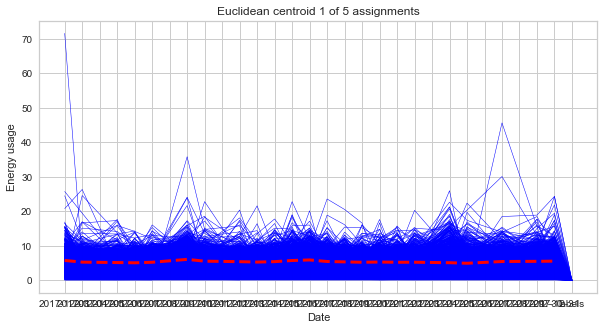

  0%|          | 0/3248 [00:00<?, ?it/s]

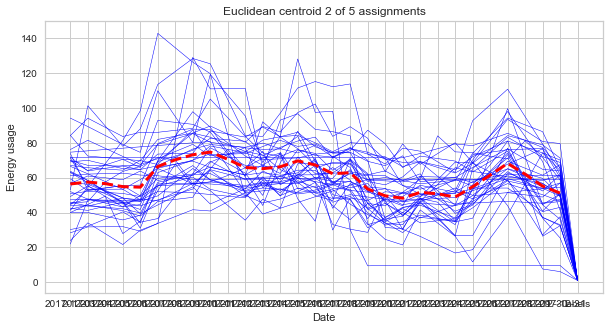

  0%|          | 0/3248 [00:00<?, ?it/s]

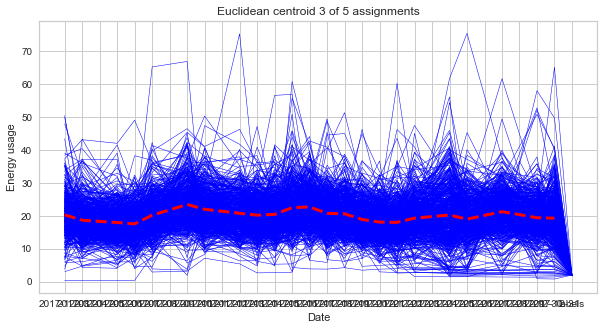

  0%|          | 0/3248 [00:00<?, ?it/s]

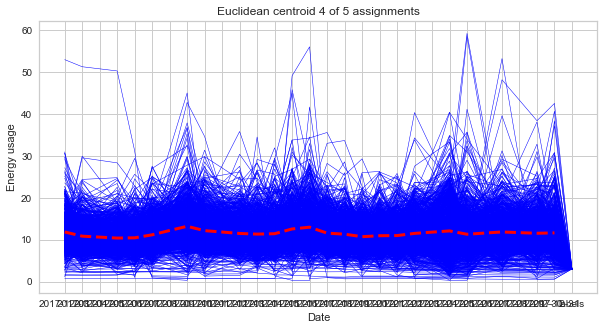

  0%|          | 0/3248 [00:00<?, ?it/s]

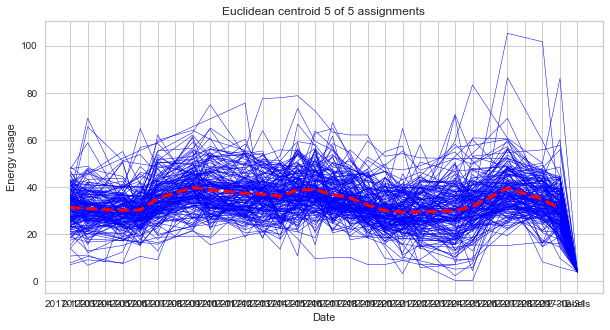

In [22]:
if not os.path.exists(f"../EDA/plots/consumption/clustering/euclidean/{k}/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/euclidean/{k}/")

# plotting the assigned points ontop of the centroids
for i in tqdm(np.unique(labels_euc)):
    plt.figure(figsize=(10,5))
    plt.title("Euclidean centroid "+str(i+1)+" of "+str(k)+" assignments")
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1))), leave=False):
        if(df_energy_last_29.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_last_29.drop("meter_id",axis=1).iloc[j].T, color="blue",lw=0.5, label="assigned")
    plt.plot(centroids[i], color="red",lw=3, label="centroid",ls="dashed")
    plt.savefig(f"../EDA/plots/consumption/clustering/euclidean/{k}/cluster_{i}")
    plt.show()
    plt.close()

In [23]:
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_labels = pd.merge(df_energy, df_energy_29_labels[{"meter_id","labels"}], on="meter_id",how="inner")
df_energy_labels

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,labels
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395,0
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751,2
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633,3
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452,2
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,...,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480,3
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,...,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401,0
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,...,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148,0
3246,0x47218b46abb2fcaade487a211911406dc6e13730,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,...,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201,4


  0%|          | 0/5 [00:00<?, ?it/s]

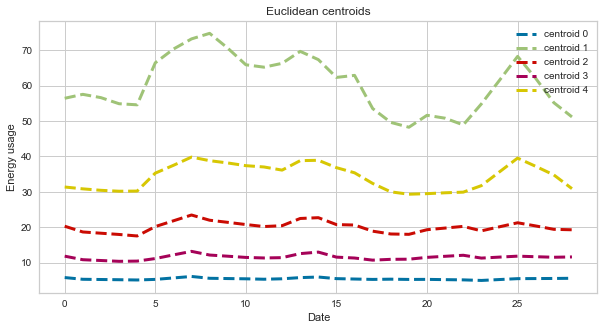

In [24]:
# plotting the centroids on top of eachother
plt.figure(figsize=(10,5))
plt.title("Euclidean centroids")
plt.xlabel("Date")
plt.ylabel("Energy usage")
for i in tqdm(np.unique(labels_euc)):
    plt.plot(centroids[i],lw=3, label=f"centroid {i}",ls="dashed")
plt.legend()
plt.savefig(f"../EDA/plots/consumption/clustering/euclidean/{k}/cluster_all")
plt.show()
plt.close()

In [25]:

# #running inside function to aid in freeing memory
# def plot_29_days():

#     # plotting all the assigned data on top of each other
#     # last 29 days

#     colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

#     plt.figure(figsize=(15,15))
#     plt.title("last 29 days clusters")
#     plt.xlabel("Date")
#     plt.ylabel("Energy usage")
#     plt.locator_params(axis='x', nbins=10)

#     for i in tqdm(np.unique(labels_euc)):


#         #plotting the one with no missing nans in december
#         for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
#             if(df_energy_29_labels.drop("meter_id",axis=1).iloc[j].labels==i):
#                 plt.plot(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

#     plt.savefig(f"../EDA/plots/consumption/clustering/euclidean/{k}/clusters_last_29_ts.png")
#     plt.show()
#     plt.clf()
#     plt.close()
    
# plot_29_days()
# gc.collect()

In [26]:
# #running in a function to aid in freeing memory
# def plot_all_days():

#     # plotting all the assigned data on top of each other
#     # all data

#     colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

#     plt.figure(figsize=(15,15))
#     plt.title("year long clusters")
#     plt.xlabel("Date")
#     plt.ylabel("Energy usage")
#     plt.locator_params(axis='x', nbins=10)

#     for i in tqdm(np.unique(labels_euc)):


#         #plotting the one with no missing nans in december
#         for j in tqdm(range(len(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
#             if(df_energy_labels.drop("meter_id",axis=1).iloc[j].labels==i):
#                 plt.plot(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

#     plt.savefig(f"../EDA/plots/consumption/clustering/euclidean/{k}/clusters_all_ts.png")
#     plt.show()
#     plt.clf()
#     plt.close()
    
# plot_all_days()
# gc.collect()

## Clustering the data via dba kmeans

* adaption of dtw using averages to be faster and more accurate

### Using the elbow method to find the best value for k for dba

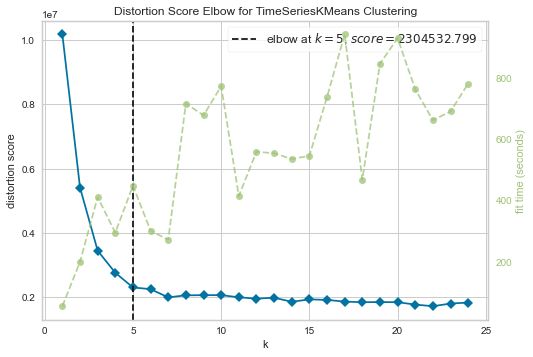

<AxesSubplot:title={'center':'Distortion Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# elbow method for getting best value for k
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
if not os.path.exists(f"../EDA/plots/consumption/clustering/dba/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/dba/")


clusterer = TimeSeriesKMeans(n_init=2, metric="dtw", max_iter_barycenter=10)
visualizer = KElbowVisualizer(clusterer, k=(1,25))

visualizer.fit(df_energy_last_29.drop("meter_id", axis=1))
# plt.title("DBA kMeans Elbow")
plt.savefig("../EDA/plots/consumption/Clustering/dba/_elbow.png")
visualizer.show()

In [28]:
# k value (how many clusters)
k = 6

### Running DBA kMeans to cluster the data using the optimal k elbow

In [29]:
#fitting the dba kmeans
clusterer = TimeSeriesKMeans(n_clusters=k, n_init=2, metric="dtw", max_iter_barycenter=10)
clusterer.fit(df_energy_last_29.drop("meter_id", axis=1))

TimeSeriesKMeans(max_iter_barycenter=10, metric='dtw', n_clusters=6, n_init=2)

In [30]:
# getting the centroids
centroids = clusterer.cluster_centers_

In [31]:
#predicting which meters belong to which cluster
labels_dba = clusterer.predict(df_energy_last_29.drop("meter_id",axis=1))
labels_dba


C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 3248 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


array([0, 3, 5, ..., 0, 2, 2], dtype=int64)

In [32]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_labels = df_energy_last_29
df_energy_29_labels["labels"]=labels_dba
df_energy_29_labels

,meter_id,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,...,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,labels
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,3.517,2.93300,3.08500,3.237,4.4710,3.7410,5.48250,7.224,4.951,...,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395,0
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,18.057,18.34500,17.41900,16.493,17.2510,23.4690,24.09950,24.730,24.597,...,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751,3
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,16.324,8.21138,9.81869,11.426,6.3985,20.0265,16.22475,12.423,18.379,...,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633,5
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,14.012,23.07300,20.08750,17.102,14.1100,23.3150,21.49350,19.672,21.023,...,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452,3
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,30.378,27.22400,29.92500,32.626,30.5070,35.3880,41.99750,48.607,54.760,...,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,10.054,10.32100,9.88000,9.439,9.6750,9.9760,10.30550,10.635,10.650,...,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480,5
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,3.170,9.96700,7.92450,5.882,3.5980,5.8620,6.81600,7.770,5.091,...,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401,0
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.727,6.03800,5.80150,5.565,5.7350,7.2410,6.46800,5.695,8.143,...,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148,0
3246,0x47218b46abb2fcaade487a211911406dc6e13730,25.614,29.31700,29.15450,28.992,23.8700,28.7260,29.28500,29.844,31.899,...,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201,2


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

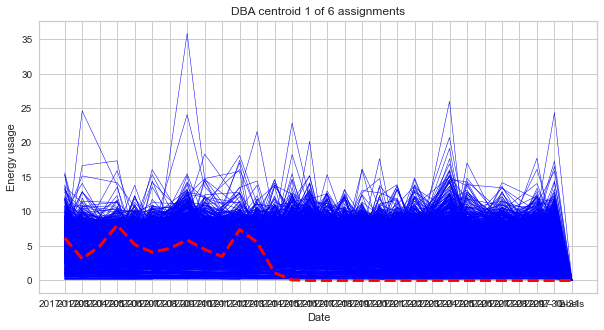

  0%|          | 0/3248 [00:00<?, ?it/s]

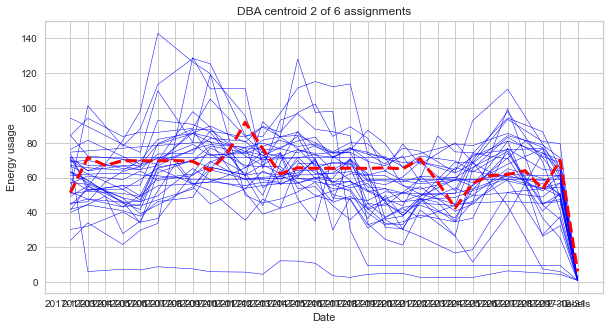

  0%|          | 0/3248 [00:00<?, ?it/s]

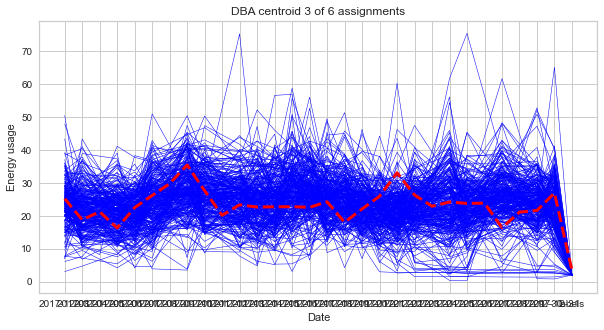

  0%|          | 0/3248 [00:00<?, ?it/s]

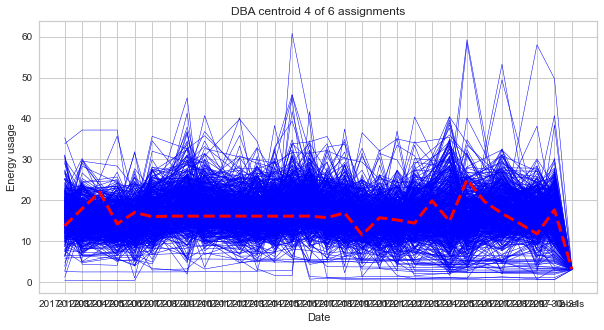

  0%|          | 0/3248 [00:00<?, ?it/s]

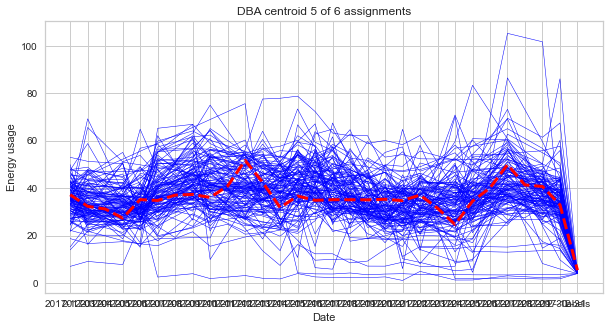

  0%|          | 0/3248 [00:00<?, ?it/s]

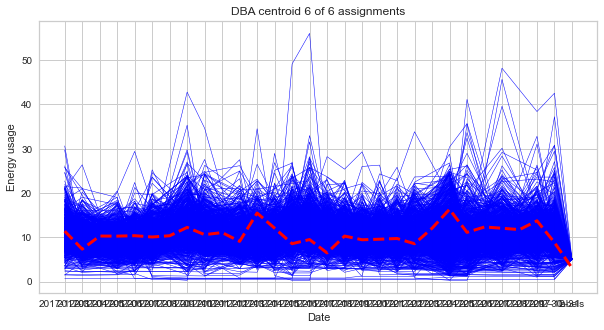

In [33]:
if not os.path.exists(f"../EDA/plots/consumption/clustering/dba/{k}/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/dba/{k}/")


# plotting the assigned points ontop of the centroids
for i in tqdm(np.unique(labels_dba)):
    plt.figure(figsize=(10,5))
    plt.title("DBA centroid "+str(i+1)+" of "+str(k)+" assignments")
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1))), leave=False):
        if(df_energy_last_29.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_last_29.drop("meter_id",axis=1).iloc[j].T, color="blue",lw=0.5, label="assigned")
    plt.plot(centroids[i], color="red",lw=3, label="centroid", ls="dashed")
    plt.savefig(f"../EDA/plots/consumption/clustering/dba/{k}/cluster_{i}")
    plt.show()
    plt.close()

In [34]:
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_labels = pd.merge(df_energy, df_energy_29_labels[{"meter_id","labels"}], on="meter_id",how="inner")
df_energy_labels

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,labels
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395,0
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751,3
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633,5
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452,3
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,...,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480,5
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,...,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401,0
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,...,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148,0
3246,0x47218b46abb2fcaade487a211911406dc6e13730,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,...,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201,2


  0%|          | 0/6 [00:00<?, ?it/s]

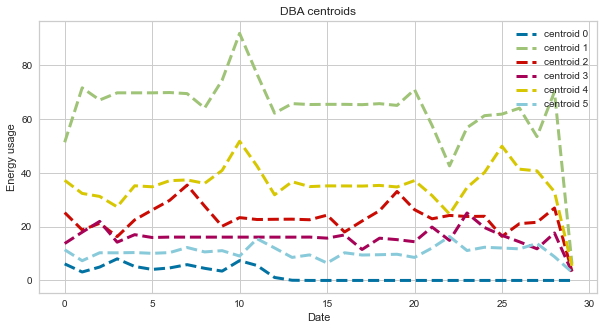

In [35]:
# plotting the centroids on top of eachother
plt.figure(figsize=(10,5))
plt.title("DBA centroids")
plt.xlabel("Date")
plt.ylabel("Energy usage")
for i in tqdm(np.unique(labels_dba)):
    plt.plot(centroids[i],lw=3, label=f"centroid {i}",ls="dashed")
plt.legend()
plt.savefig(f"../EDA/plots/consumption/clustering/dba/{k}/cluster_all")
plt.show()
plt.close()

In [36]:
# # plotting all the assigned data on top of each other
# # last 29 days

# colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

# plt.figure(figsize=(15,15))
# plt.title("last 29 days clusters")
# plt.xlabel("Date")
# plt.ylabel("Energy usage")
# plt.locator_params(axis='x', nbins=10)

# for i in tqdm(np.unique(labels_dba)):

    
#     #plotting the one with no missing nans in december
#     for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
#         if(df_energy_29_labels.drop("meter_id",axis=1).iloc[j].labels==i):
#             plt.plot(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

# plt.savefig(f"../EDA/plots/consumption/clustering/dba/{k}/clusters_last_29_ts.png")
# plt.show()
# plt.close()

In [37]:
# # plotting all the assigned data on top of each other
# # all data

# colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

# plt.figure(figsize=(15,15))
# plt.title("year long clusters")
# plt.xlabel("Date")
# plt.ylabel("Energy usage")
# plt.locator_params(axis='x', nbins=10)

# for i in tqdm(np.unique(labels_dba)):

    
#     #plotting the one with no missing nans in december
#     for j in tqdm(range(len(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
#         if(df_energy_labels.drop("meter_id",axis=1).iloc[j].labels==i):
#             plt.plot(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

# plt.savefig(f"../EDA/plots/consumption/clustering/dba/{k}/clusters_all_ts.png")
# plt.show()
# plt.close()

## Clustering the data via soft dtw kmeans

* soft-dtw; slow and less accurate than dba

### Finding elbow of soft-dtw

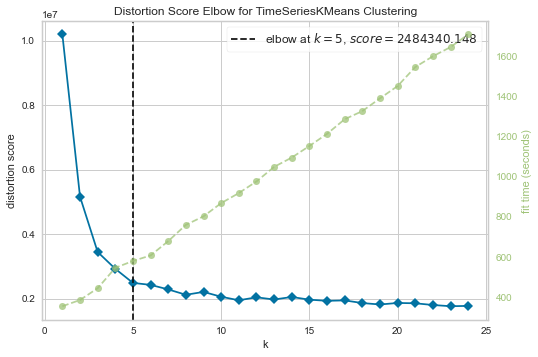

<AxesSubplot:title={'center':'Distortion Score Elbow for TimeSeriesKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
# elbow method for getting best value for k
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
if not os.path.exists(f"../EDA/plots/consumption/clustering/soft-dtw/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/soft-dtw/")

clusterer = TimeSeriesKMeans(metric="softdtw", metric_params={"gamma":0.01})
visualizer = KElbowVisualizer(clusterer, k=(1,25))

visualizer.fit(df_energy_last_29.drop("meter_id", axis=1))
# plt.title("soft-dtw kMeans Elbow")
plt.savefig("../EDA/plots/consumption/Clustering/soft-dtw/_elbow.png")
visualizer.show()

In [39]:
# k value (how many clusters)
k = 5

### Running soft-dtw kmeans on the optimal k value

In [40]:
#fitting the soft-dtw kmeans
clusterer = TimeSeriesKMeans(n_clusters=k, metric="softdtw", metric_params={"gamma":0.01})
clusterer.fit(df_energy_last_29.drop("meter_id", axis=1))

TimeSeriesKMeans(metric='softdtw', metric_params={'gamma': 0.01}, n_clusters=5)

In [41]:
# getting the centroids
centroids = clusterer.cluster_centers_

In [42]:
#predicting which meters belong to which cluster
labels_dtw = clusterer.predict(df_energy_last_29.drop("meter_id",axis=1))
labels_dtw


C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 3248 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


array([4, 2, 0, ..., 4, 2, 2], dtype=int64)

In [43]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_labels = df_energy_last_29
df_energy_29_labels["labels"]=labels_dtw
df_energy_29_labels

,meter_id,2017-12-03,2017-12-04,2017-12-05,2017-12-06,2017-12-07,2017-12-08,2017-12-09,2017-12-10,2017-12-11,...,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,labels
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,3.517,2.93300,3.08500,3.237,4.4710,3.7410,5.48250,7.224,4.951,...,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395,4
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,18.057,18.34500,17.41900,16.493,17.2510,23.4690,24.09950,24.730,24.597,...,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751,2
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,16.324,8.21138,9.81869,11.426,6.3985,20.0265,16.22475,12.423,18.379,...,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633,0
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,14.012,23.07300,20.08750,17.102,14.1100,23.3150,21.49350,19.672,21.023,...,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452,0
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,30.378,27.22400,29.92500,32.626,30.5070,35.3880,41.99750,48.607,54.760,...,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,10.054,10.32100,9.88000,9.439,9.6750,9.9760,10.30550,10.635,10.650,...,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480,4
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,3.170,9.96700,7.92450,5.882,3.5980,5.8620,6.81600,7.770,5.091,...,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401,4
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.727,6.03800,5.80150,5.565,5.7350,7.2410,6.46800,5.695,8.143,...,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148,4
3246,0x47218b46abb2fcaade487a211911406dc6e13730,25.614,29.31700,29.15450,28.992,23.8700,28.7260,29.28500,29.844,31.899,...,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201,2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

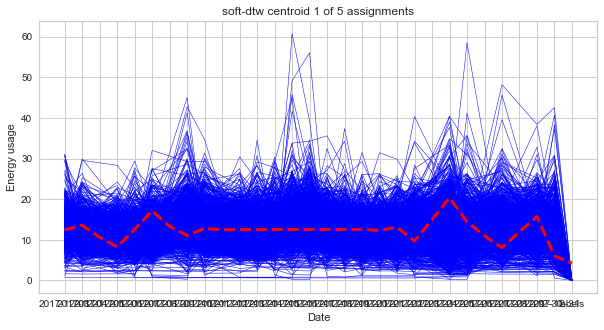

  0%|          | 0/3248 [00:00<?, ?it/s]

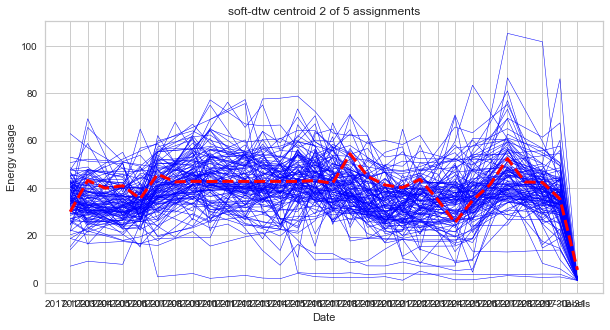

  0%|          | 0/3248 [00:00<?, ?it/s]

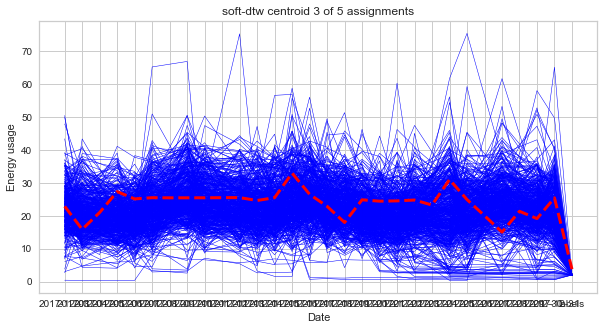

  0%|          | 0/3248 [00:00<?, ?it/s]

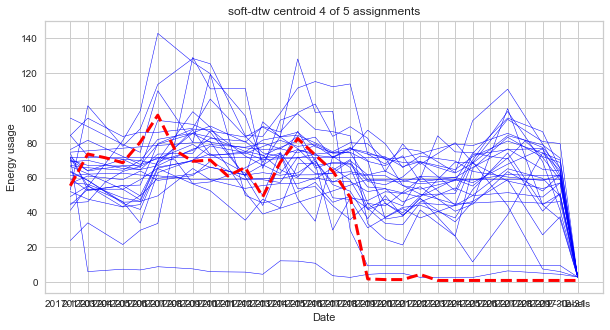

  0%|          | 0/3248 [00:00<?, ?it/s]

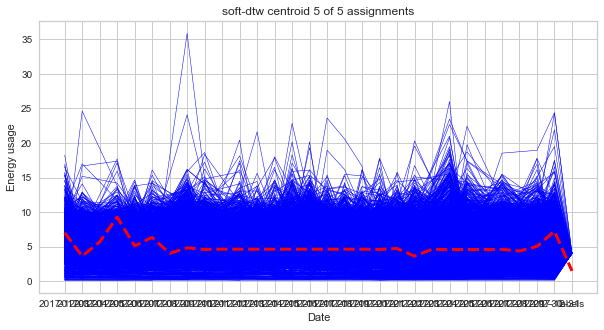

In [44]:
if not os.path.exists(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/")

# plotting the assigned points ontop of the centroids
for i in tqdm(np.unique(labels_dtw)):
    plt.figure(figsize=(10,5))
    plt.title("soft-dtw centroid "+str(i+1)+" of "+str(k)+" assignments")
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1))), leave=False):
        if(df_energy_last_29.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_last_29.drop("meter_id",axis=1).iloc[j].T, color="blue",lw=0.5, label="assigned")
    plt.plot(centroids[i], color="red",lw=3, label="centroid",ls="dashed")
    plt.savefig(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/cluster_{i}")
    plt.show()
    plt.close()

In [45]:
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_labels = pd.merge(df_energy, df_energy_29_labels[{"meter_id","labels"}], on="meter_id",how="inner")
df_energy_labels

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,labels
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395,4
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751,2
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633,0
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452,0
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,...,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480,4
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,...,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401,4
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,...,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148,4
3246,0x47218b46abb2fcaade487a211911406dc6e13730,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,...,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201,2


  0%|          | 0/5 [00:00<?, ?it/s]

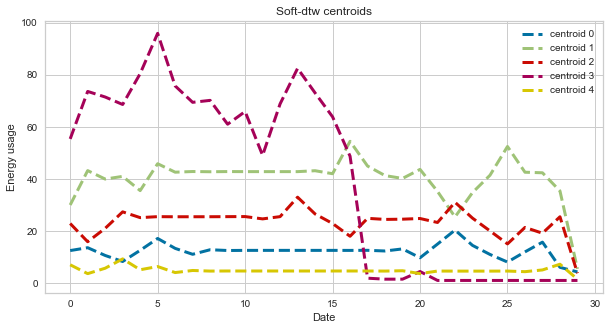

In [46]:
# plotting the centroids on top of eachother
plt.figure(figsize=(10,5))
plt.title("Soft-dtw centroids")
plt.xlabel("Date")
plt.ylabel("Energy usage")
for i in tqdm(np.unique(labels_dtw)):
    plt.plot(centroids[i],lw=3, label=f"centroid {i}",ls="dashed")
plt.legend()
plt.savefig(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/cluster_all")
plt.show()
plt.close()

In [47]:
# # plotting all the assigned data on top of each other
# # last 29 days

# colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

# plt.figure(figsize=(15,15))
# plt.title("last 29 days clusters")
# plt.xlabel("Date")
# plt.ylabel("Energy usage")
# plt.locator_params(axis='x', nbins=10)

# for i in tqdm(np.unique(labels_dtw)):

    
#     #plotting the one with no missing nans in december
#     for j in tqdm(range(len(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
#         if(df_energy_29_labels.drop("meter_id",axis=1).iloc[j].labels==i):
#             plt.plot(df_energy_29_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

# plt.savefig(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/clusters_last_29_ts.png")
# plt.show()
# plt.close()

In [48]:
# # plotting all the assigned data on top of each other
# # all data

# colours = ["red","blue","green","magenta","cyan","orange","brown","grey","pink","purple","black","olive"]

# plt.figure(figsize=(15,15))
# plt.title("year long clusters")
# plt.xlabel("Date")
# plt.ylabel("Energy usage")
# plt.locator_params(axis='x', nbins=10)

# for i in tqdm(np.unique(labels_dtw)):

    
#     #plotting the one with no missing nans in december
#     for j in tqdm(range(len(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
#         if(df_energy_labels.drop("meter_id",axis=1).iloc[j].labels==i):
#             plt.plot(df_energy_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

# plt.savefig(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/clusters_all_ts.png")
# plt.show()
# plt.close()



# Conclusions:

* DBA gave the best performance out of the 3 tested time series suited kmeans methods
    * Backs up findings from here https://blog.acolyer.org/2016/05/13/dynamic-time-warping-averaging-of-time-series-allows-faster-and-more-accurate-classification/
    
* Hence will use the DBA found classifications


# Saving this data

In [49]:
#assigning the labels from dba on df_energy_last_29
df_energy_29_labels = df_energy_last_29
df_energy_29_labels["labels"]=labels_dba
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_labels = pd.merge(df_energy, df_energy_29_labels[{"meter_id","labels"}], on="meter_id",how="inner")
df_energy_labels

,meter_id,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,...,2017-12-23,2017-12-24,2017-12-25,2017-12-26,2017-12-27,2017-12-28,2017-12-29,2017-12-30,2017-12-31,labels
0,0xa62b9f23553ff183f61e2bf943aab3d5983d02d7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.397,5.1075,4.818,3.931,4.2170,4.503,4.8160,5.129,5.395,0
1,0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.327,14.6315,14.936,16.174,20.3960,24.618,19.8925,15.167,11.751,3
2,0x4a1ed36825360a058cec2bdd409fc2459e1ce54f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.320,7.3520,7.384,14.425,16.0650,17.705,13.3355,8.966,4.633,5
3,0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.477,11.7255,10.974,19.646,21.8195,23.993,19.9170,15.841,14.452,3
4,0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.538,21.9445,8.351,9.957,17.9140,25.871,36.0725,46.274,16.901,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3243,0x7dd7a7b8ee1bec7c44b24f738c752482f6161065,2.317,2.301,2.352,2.516,2.229,2.354,2.397,2.397,2.269,...,9.231,9.2235,9.216,9.336,9.6840,10.032,9.8945,9.757,9.480,5
3244,0xfdaf9f857621ec06f2cf801f42a020a322835090,14.437,16.274,7.031,17.018,17.603,15.005,8.987,8.490,10.136,...,2.828,3.8230,4.818,3.357,8.1315,12.906,8.0140,3.122,3.401,0
3245,0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18,7.824,7.517,5.398,6.788,7.360,6.898,7.321,8.042,8.207,...,5.919,5.9980,6.077,7.761,6.6080,5.455,5.5670,5.679,8.148,0
3246,0x47218b46abb2fcaade487a211911406dc6e13730,23.965,28.689,27.664,29.229,29.548,27.909,26.923,21.277,23.452,...,19.979,20.1925,20.406,23.668,27.7900,31.912,29.1125,26.313,24.201,2


In [50]:
# if(os.path.exists(f"../Data/Preprocessed_Data/consumption_clustered.pkl")==False):
#         df_energy_labels.to_pickle(f"../Data/Preprocessed_Data/consumption_clustered.pkl")
df_energy_labels.to_pickle(f"../Data/Preprocessed_Data/consumption_clustered.pkl")